## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

DOĞUKAN AYTEKİN 2200356003

## 1. Implementing a CNN from Scratch (50 points)

### 1.1. Introduction
* Brief overview of the task.
* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
* Description of the dataset used for classification.


* The main objective of this section is to creating a CNN model from scratch and optimize it for our Animals-10 data to fit best.

* The main components of a CNN architecture include convolutional layers, pooling layers, and fully connected layers. Convolutional layers using for extracting deeper features  from images. Pooling layers for reducing spatial dimensions and extract key features. Fully connected layers using for classify the input to final class.

* CNNs are used in image classification because they they gave good result in classifying them. Because of the image datas are built of some spatial structures CNN's are good to classify and learn them.

* This dataset contains 10 different animal types. Each has 450 samples and in pre-processing step we split in training,validation,test sets with 3000,750,750 ratio.

### 1.2. Data Loading and Preprocessing (5 points)

In [2]:
## Import necessary libraries
import os
import numpy as np
import pandas as pd
import zipfile
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display
from torch import optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from google.colab import drive


In [ ]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets

* In this step I take the subset.zip file from the drive account which is same with my Colab account then extract the zip to use the file.

In [3]:
# take the subset file from drive and pass to cuda GPU
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

# extract the subset.zip
zip_train = zipfile.ZipFile('/content/drive/MyDrive/subset.zip','r')
zip_train.extractall('/tmp')
zip_train.close()


Mounted at /content/drive
Using: cuda


* In this section I find the mean and standart deviation vectors to transform the data properly in next section

In [4]:
# resize the image to find the mean and standart devation vector
transform_without_normalization = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset_without_normalization = datasets.ImageFolder(root="/tmp/subset", transform=transform_without_normalization)

# create loader and find mean and standart deviation vector
loader = torch.utils.data.DataLoader(dataset_without_normalization, batch_size=len(dataset_without_normalization), num_workers=0)
data = next(iter(loader))
Mean = data[0].mean(dim=(0, 2, 3))
Std = data[0].std(dim=(0, 2, 3))
print("Mean vector : " , {Mean} )
print("Std vector : "  ,{Std})

Mean vector :  {tensor([0.5107, 0.4953, 0.4075])}
Std vector :  {tensor([0.2641, 0.2593, 0.2775])}


* In this step I applied Data Augmentation, visualized the distrubution of data and created the data loaders .

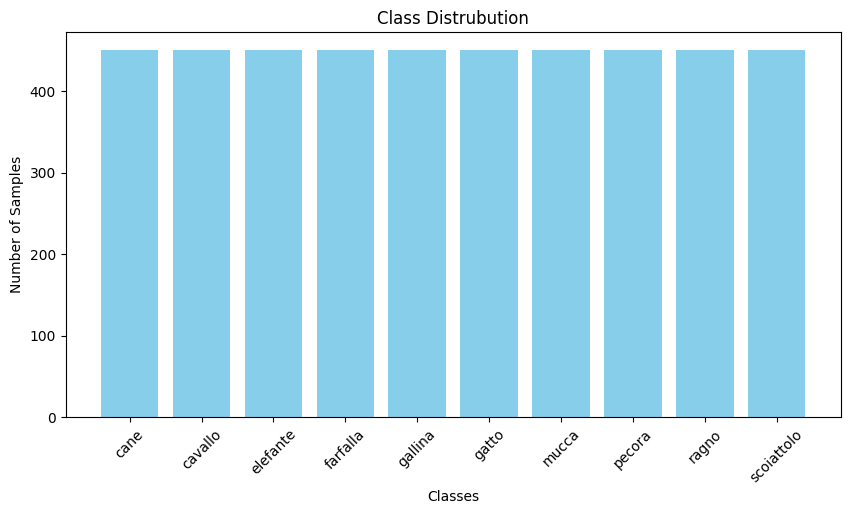

In [5]:
#Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=Mean, std=Std)
])

# split the data to train,validation,test
dataset = torchvision.datasets.ImageFolder("/tmp/subset", transform=transform)
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, (3000, 750, 750))


# find the labels and visualize the data distrubution
class_names = dataset.classes
class_counts = dataset.targets

class_count_dict = {}
for label in class_counts:
    if label in class_count_dict:
        class_count_dict[label] += 1
    else:
        class_count_dict[label] = 1

plt.figure(figsize=(10, 5))
plt.bar(class_names, [class_count_dict[i] for i in range(len(class_names))], color='skyblue')
plt.title("Class Distrubution")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# prepare the loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=16,
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
)

### 1.3. Define your CNN architecture (10 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.

* I use 5 convolutional layer with BatchNorms and pooling layers in every convolutional layer. In the end of convolutional layers I have a fully connected layer with softmax activation function. I choose relu for convolutional layers and softmax activation function for fully connected layer because for classification problem they gave me better results than other problems for this data. Also I use pooling for every convolutional layer because when I don't apply them the data is getting very bigger and the process time changed to be very slower but the result accuracy is similar so I choose to put them there.

In [ ]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes

In [6]:
import torch.nn as nn

# create the CNN model's architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32, affine=True)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64, affine=True)


        self.conv3 = nn.Conv2d(64, 128, 3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128, affine=True)


        self.conv4 = nn.Conv2d(128, 256, 3,stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256, affine=True)


        self.conv5 = nn.Conv2d(256, 512, 3,stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512, affine=True)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32768, 10)


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.pool(nn.functional.relu(self.bn4(self.conv4(x))))
        x = self.pool(nn.functional.relu(self.bn5(self.conv5(x))))


        x = x.view(x.size(0), -1)

        x=self.fc1(x)
        x = F.log_softmax(x, dim=1)
        return x


### 1.4 Prepare the model for training (5 points)
* Explain your choice of loss functions and optimization algorithms.

* I choose Adam optimizer and CrossEntropyLoss because in the general use of CNN's Adam optimizer and CrossEntropyLoss gives better results . I choose Learning rate as 0.001 because in my experiments this is the best learning rate value for this dataset in my model.

In [ ]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)

In [ ]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)

In [7]:
# pass model to cuda and create the loss function and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

### 1.5 Train and Validate the CNN model (10 points)

In [ ]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epohs)

In [ ]:
## You can conduct experiments with different hyperparameters to get the best performing model.

* In the next 2 steps I create the train and test function which is used for our scratch model and also resnet50 models.

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=7):
    best_val_accuracy = 0.0
    best_model_path = "best_model.pth"

    # lists to plot the loss and accuracy 
    loss_list = []
    accuracy_list = []

    current_patience = 0
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_predictions = []
        train_targets = []

        for images, labels in train_loader:
            optimizer.zero_grad()
            images = images.to(device=device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_predictions.extend(predicted.tolist())
            train_targets.extend(labels.tolist())
            
        loss_list.append(loss.item())
        train_accuracy = train_correct / train_total
        train_precision = precision_score(train_targets, train_predictions, average='macro')
        train_recall = recall_score(train_targets, train_predictions, average='macro')
        train_f1 = f1_score(train_targets, train_predictions, average='macro')

        model.eval()
        with torch.no_grad():
            val_correct = 0
            val_total = 0
            val_predictions = []
            val_targets = []
            for images, labels in val_loader:
                images = images.to(device=device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_predictions.extend(predicted.tolist())
                val_targets.extend(labels.tolist())

        val_accuracy = val_correct / val_total
        val_precision = precision_score(val_targets, val_predictions, average='macro')
        val_recall = recall_score(val_targets, val_predictions, average='macro')
        val_f1 = f1_score(val_targets, val_predictions, average='macro')

        accuracy_list.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}, Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}, Validation Accuracy: {val_accuracy:.2f}, Validation Precision: {val_precision:.2f}, Validation Recall: {val_recall:.2f}, Validation F1: {val_f1:.2f}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)



    return model,loss_list,accuracy_list


In [9]:
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device=device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            predictions.extend(predicted.tolist())
            targets.extend(labels.tolist())

    test_loss = running_loss / total
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return test_loss,accuracy,precision,recall,f1


In [10]:
model,loss_list , accuracy_list = train(model, train_loader,val_loader, criterion, optimizer)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/100], Train Accuracy: 0.15, Train Precision: 0.15, Train Recall: 0.15, Train F1: 0.15, Validation Accuracy: 0.15, Validation Precision: 0.32, Validation Recall: 0.16, Validation F1: 0.12
Epoch [2/100], Train Accuracy: 0.21, Train Precision: 0.20, Train Recall: 0.21, Train F1: 0.21, Validation Accuracy: 0.29, Validation Precision: 0.27, Validation Recall: 0.28, Validation F1: 0.24


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/100], Train Accuracy: 0.28, Train Precision: 0.27, Train Recall: 0.28, Train F1: 0.27, Validation Accuracy: 0.30, Validation Precision: 0.29, Validation Recall: 0.31, Validation F1: 0.28
Epoch [4/100], Train Accuracy: 0.33, Train Precision: 0.32, Train Recall: 0.32, Train F1: 0.32, Validation Accuracy: 0.33, Validation Precision: 0.43, Validation Recall: 0.33, Validation F1: 0.30
Epoch [5/100], Train Accuracy: 0.36, Train Precision: 0.35, Train Recall: 0.35, Train F1: 0.35, Validation Accuracy: 0.36, Validation Precision: 0.38, Validation Recall: 0.36, Validation F1: 0.34
Epoch [6/100], Train Accuracy: 0.38, Train Precision: 0.38, Train Recall: 0.38, Train F1: 0.38, Validation Accuracy: 0.37, Validation Precision: 0.40, Validation Recall: 0.37, Validation F1: 0.35
Epoch [7/100], Train Accuracy: 0.39, Train Precision: 0.39, Train Recall: 0.39, Train F1: 0.39, Validation Accuracy: 0.35, Validation Precision: 0.41, Validation Recall: 0.35, Validation F1: 0.33
Epoch [8/100], Train

In [11]:
def plotTrainLossAndAccuracy(loss_list, accuracy_list,num_epochs):
  if torch.is_tensor(loss_list):
      loss_list = loss_list.cpu().detach().numpy()
  if torch.is_tensor(accuracy_list):
      accuracy_list = accuracy_list.cpu().detach().numpy()
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(loss_list, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(1, num_epochs + 1), accuracy_list, label='Validation Accuracy', color='r')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy over Epochs')
  plt.legend()

  plt.tight_layout()
  plt.show()

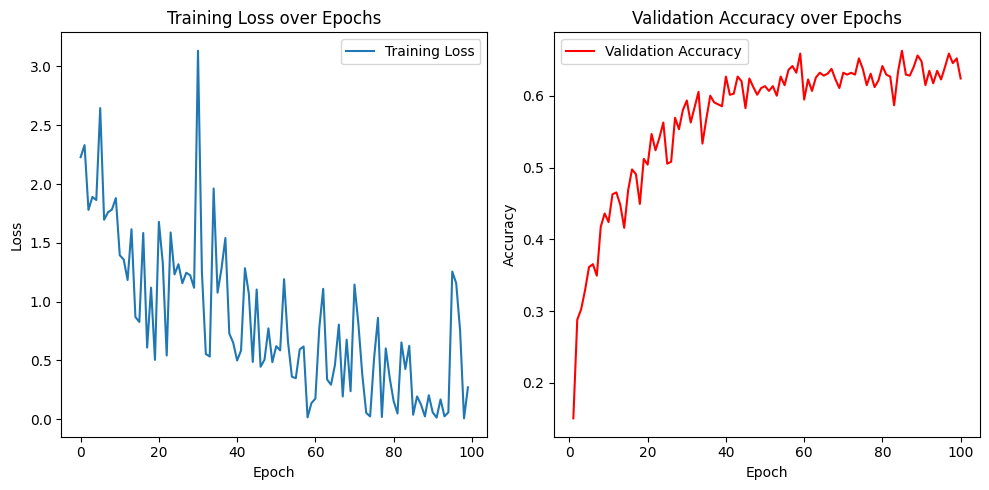

In [12]:
plotTrainLossAndAccuracy(loss_list, accuracy_list,100)

Mention about, why did you choose your learning rate and batch size?

In [ ]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.

### 1.6 Evaluate the trained model on the test set (10 points)

In [ ]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

Test Loss: 1.9181, Accuracy: 0.6147, Precision: 0.6307, Recall: 0.6147, F1: 0.6168


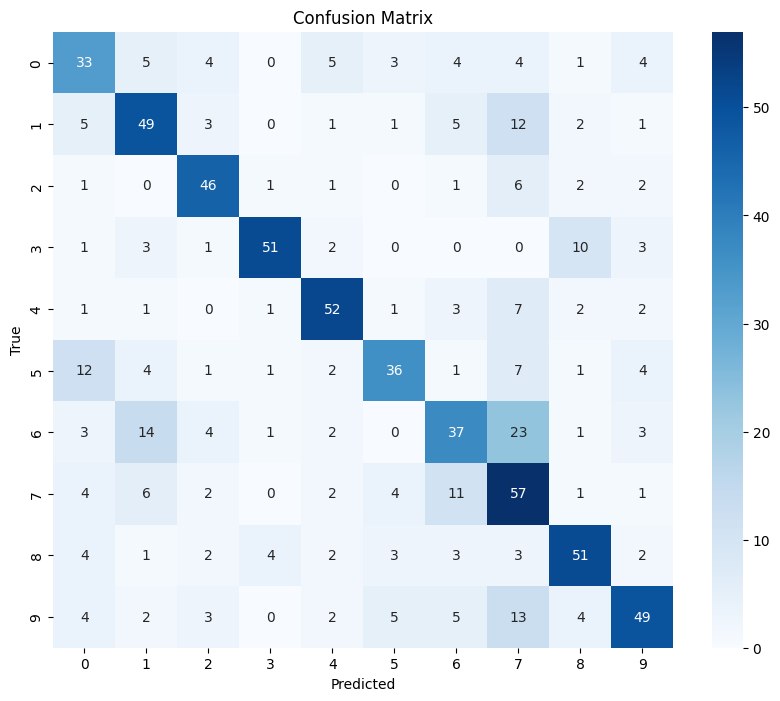

(1.9181393273671468,
 0.6146666666666667,
 0.6306637846053121,
 0.6146666666666667,
 0.6167929647262616)

In [13]:
test(model, test_loader, criterion)

### 1.7 Conclusion and interpretation (10 points)
* Summarize the performance of the model on the test set
* Discuss any challenges encountered during training and potential areas for improvement
* Reflect on the overall effectiveness of the chosen CNN architecture and training approach

* My model takes 0.61 accuracy on the test set this is a good result for a scratch CNN model with this number of data. For one of my experiments I take 0.70 max accuracy in validation set but because of I forgot to set the seeds in that experiment I couldn't take it anymore.

* The biggest challange I encountered during training is the running time of the model even tough I use google colab it takes nearly 1 hour to done. Because of that the making experiment on the model is very hard and challenging.

* Also other challenge is the overfitting problem of the model in the beginings of the assignment my model is overfiting very early to the data and It causes the low accuracies but then I applied the Data Augmentation it really helped to correct the model. Also changin optimizer from SGD to Adam is helped me to improve my model a lot.

## 2. Exploring Transfer Learning with ResNet50 (50 points)

### 2.1. Introduction
* Brief overview of the task.
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?

* In the second section of the assignment we train the model which is already trained. We freeze some of the layers then experiment on the accuracy via the our training.

* Fine-tunnig is training a model on our dataset which is pre-trained before. We should do this method if we are not able to access more data to achieve good accuracy results. We train only last layers because in first layers most of the models learns same things but in deepers layers learning is on the data's deeper spatial structures.

### 2.2. Load the pre-trained ResNet50 model (5 points)


In [ ]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.

In [ ]:
import torchvision.models as models

### 2.3 Modify the ResNet50 model for transfer learning (25 points)

In [ ]:
## Freeze all layers of the ResNet50 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet50 model on the animal-10 image dataset. (base model)

In [ ]:
# load resnet50
resnet50 = models.resnet50(pretrained=True)

# freeze all layers
for param in resnet50.parameters():
  param.requires_grad = False

# replace the final fully connected layer and unfreeze
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

#choose criterion and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(resnet50.fc.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
## Define another ResNet50 model
## Freeze all layers of the ResNet50 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet50 model and again proceed with training. (second model)

In [ ]:
# load resnet50
resnet50_second = models.resnet50(pretrained=True)

# freeze all layers
for param in resnet50_second.parameters():
    param.requires_grad = False

# replace the final fully connected layer
resnet50_second.fc = nn.Linear(resnet50_second.fc.in_features, 10)

# Unfreeze layer3, layer4 and fully connected one
for name, param in resnet50_second.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True

#choose criterion and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(resnet50_second.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
## Define another ResNet50 model
## Replace the final fully connected layer with a new FC layer matching the number of classes.
## Finetune the weights of all layers in the ResNet50 model. (third model)

In [ ]:
# load resnet50
resnet50_third = models.resnet50(pretrained=True)

# replace the final fully connected layer
resnet50_third.fc = nn.Linear(resnet50_third.fc.in_features, 10)

# make all layers unfreezed
for param in resnet50_third.parameters():
    param.requires_grad = True
    
#choose criterion and optimizer
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(resnet50_third.parameters(), lr=0.00001)

In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

In [ ]:
resnet1, train_loss_list_1, val_accuracy_list_1 = train(resnet50.to(device), train_loader, val_loader, criterion1, optimizer1,num_epochs=10)


Epoch [1/10], Train Accuracy: 0.70, Train Precision: 0.70, Train Recall: 0.70, Train F1: 0.70, Validation Accuracy: 0.88, Validation Precision: 0.88, Validation Recall: 0.88, Validation F1: 0.87
Epoch [2/10], Train Accuracy: 0.83, Train Precision: 0.83, Train Recall: 0.83, Train F1: 0.83, Validation Accuracy: 0.90, Validation Precision: 0.91, Validation Recall: 0.90, Validation F1: 0.90
Epoch [3/10], Train Accuracy: 0.85, Train Precision: 0.85, Train Recall: 0.85, Train F1: 0.85, Validation Accuracy: 0.89, Validation Precision: 0.90, Validation Recall: 0.89, Validation F1: 0.89
Epoch [4/10], Train Accuracy: 0.84, Train Precision: 0.85, Train Recall: 0.84, Train F1: 0.84, Validation Accuracy: 0.89, Validation Precision: 0.90, Validation Recall: 0.89, Validation F1: 0.89
Epoch [5/10], Train Accuracy: 0.85, Train Precision: 0.85, Train Recall: 0.85, Train F1: 0.85, Validation Accuracy: 0.89, Validation Precision: 0.90, Validation Recall: 0.88, Validation F1: 0.89
Epoch [6/10], Train Accur

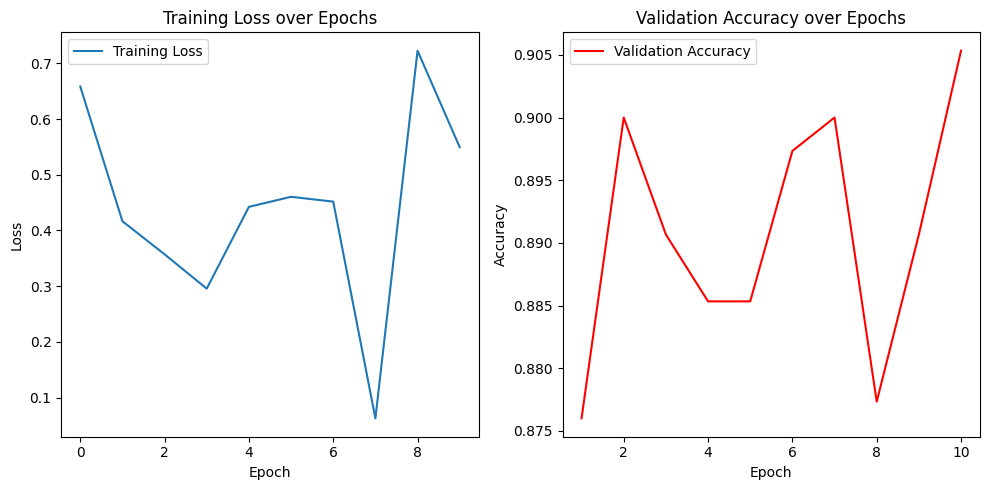

In [ ]:
plotTrainLossAndAccuracy(train_loss_list_1, val_accuracy_list_1, 10)

In [ ]:
resnet2, train_loss_list_2, val_accuracy_list_2 = train(resnet50_second.to(device), train_loader, val_loader, criterion2, optimizer2,num_epochs=10)

Epoch [1/10], Train Accuracy: 0.78, Train Precision: 0.78, Train Recall: 0.78, Train F1: 0.78, Validation Accuracy: 0.88, Validation Precision: 0.88, Validation Recall: 0.88, Validation F1: 0.88
Epoch [2/10], Train Accuracy: 0.88, Train Precision: 0.88, Train Recall: 0.88, Train F1: 0.88, Validation Accuracy: 0.90, Validation Precision: 0.90, Validation Recall: 0.90, Validation F1: 0.90
Epoch [3/10], Train Accuracy: 0.92, Train Precision: 0.92, Train Recall: 0.92, Train F1: 0.92, Validation Accuracy: 0.86, Validation Precision: 0.89, Validation Recall: 0.86, Validation F1: 0.86
Epoch [4/10], Train Accuracy: 0.93, Train Precision: 0.93, Train Recall: 0.93, Train F1: 0.93, Validation Accuracy: 0.87, Validation Precision: 0.88, Validation Recall: 0.87, Validation F1: 0.87
Epoch [5/10], Train Accuracy: 0.94, Train Precision: 0.94, Train Recall: 0.94, Train F1: 0.94, Validation Accuracy: 0.91, Validation Precision: 0.91, Validation Recall: 0.91, Validation F1: 0.91
Epoch [6/10], Train Accur

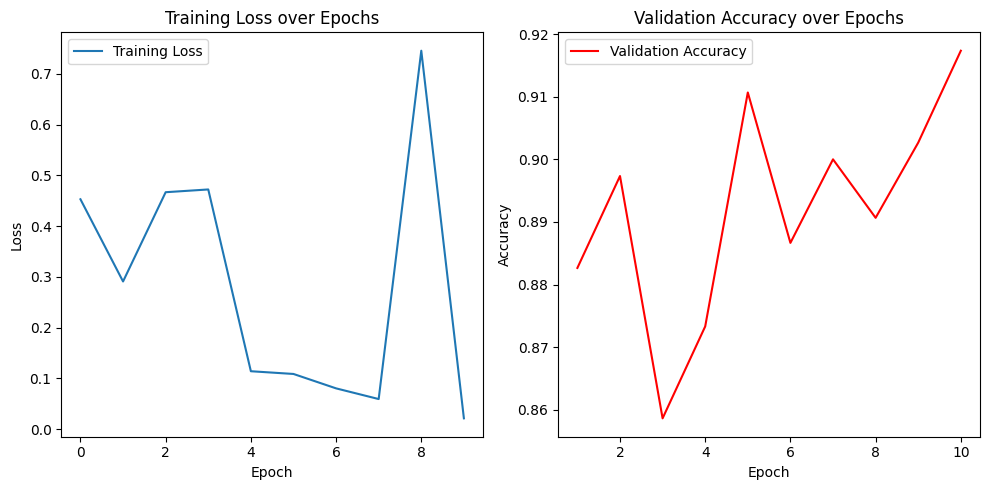

In [ ]:
plotTrainLossAndAccuracy(train_loss_list_2, val_accuracy_list_2, 10)

In [ ]:
resnet3, train_loss_list_3, val_accuracy_list_3 = train(resnet50_third.to(device), train_loader, val_loader, criterion3, optimizer3,num_epochs=10)

Epoch [1/10], Train Accuracy: 0.62, Train Precision: 0.68, Train Recall: 0.62, Train F1: 0.62, Validation Accuracy: 0.86, Validation Precision: 0.87, Validation Recall: 0.86, Validation F1: 0.86
Epoch [2/10], Train Accuracy: 0.85, Train Precision: 0.85, Train Recall: 0.85, Train F1: 0.85, Validation Accuracy: 0.91, Validation Precision: 0.91, Validation Recall: 0.91, Validation F1: 0.91
Epoch [3/10], Train Accuracy: 0.89, Train Precision: 0.89, Train Recall: 0.89, Train F1: 0.88, Validation Accuracy: 0.94, Validation Precision: 0.94, Validation Recall: 0.94, Validation F1: 0.94
Epoch [4/10], Train Accuracy: 0.91, Train Precision: 0.91, Train Recall: 0.91, Train F1: 0.91, Validation Accuracy: 0.93, Validation Precision: 0.93, Validation Recall: 0.94, Validation F1: 0.93
Epoch [5/10], Train Accuracy: 0.93, Train Precision: 0.93, Train Recall: 0.93, Train F1: 0.93, Validation Accuracy: 0.92, Validation Precision: 0.92, Validation Recall: 0.92, Validation F1: 0.92
Epoch [6/10], Train Accur

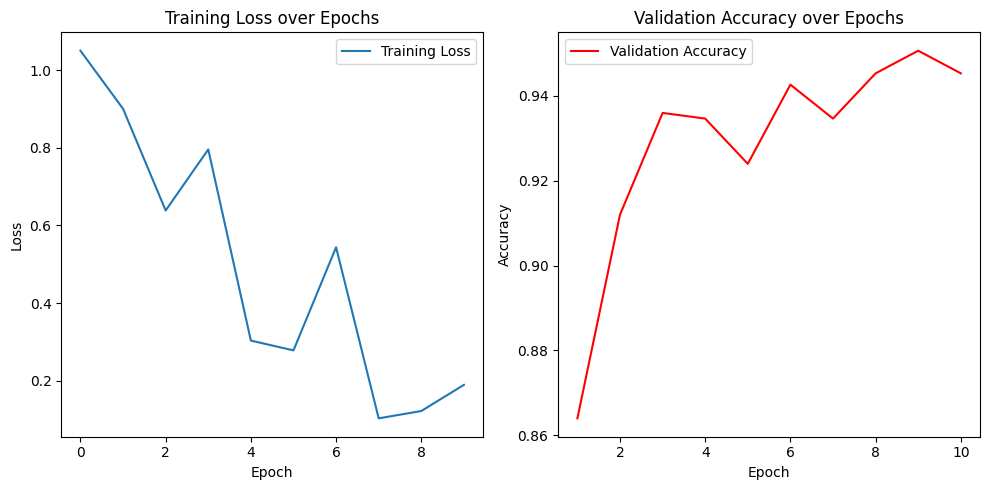

In [ ]:
plotTrainLossAndAccuracy(train_loss_list_3, val_accuracy_list_3, 10)

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

* Best performing model is the third model with all unfreezed layers. It performed better because we train all the layers of pre-trained model and it learned our dataset better.

* The practical considerations among these models entail evaluating their computational requirements, performance on specific tasks, and ease of deployment.Implementing a simple CNN model may be computationally less intensive but could lack in learning complex features compared to fine-tuning a pre-trained model.The choice between models also depends on factors such as available computational resources, dataset size, and the specific requirements of the classification task.

### 2.4 Evaluate the fine-tuned ResNet50 model (10 points)

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Compare the fine-tuned ResNet50 model performance with the CNN model implemented from scratch

Test Loss: 0.2160, Accuracy: 0.9347, Precision: 0.9367, Recall: 0.9347, F1: 0.9349


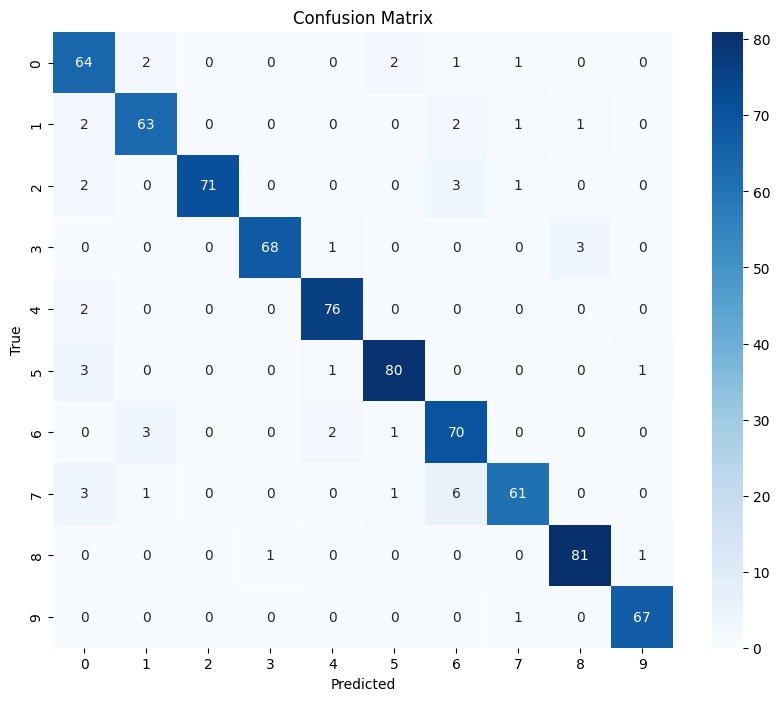

(0.21597395034631092,
 0.9346666666666666,
 0.9367022050887839,
 0.9346666666666666,
 0.93494882804162)

In [ ]:
test(resnet50_third,test_loader,criterion3)

### 2.5 Analyze advantages and disadvantages (10 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
* Discuss practical considerations when choosing between these two approaches



* In transfer learning it has advantages like the ability to achieve better performance with less data , faster model training, and reduced computational resources required. But it has also disadvantages like it is hard to adapting the model to a spesific dataset.

* When deciding between transfer learning and training from scratch, we have considerations such as the size of the data, computational resources, complexity time of the mode, and the complexity of the target task should be taken into account. Transfer learning is suitable for obtaining quick results with limited data, while training from scratch provides more flexibility but may demand more computational resources.